In [2]:
# import all modules required
import numpy as np              # for the arrays  
import matplotlib.pyplot as plt # for the plotting
import scipy.integrate as si    # to integrate numerically the equations of motion
import scipy.optimize as so     # for the bisection algorithm

# change to qt for plots in a new window
%matplotlib inline 

In [3]:
# PARAMETERS
# acceleration of gravity 
g = 9.81 # m/s^2

# mass and diameter of squash ball
m = 0.025 # kg
d = 0.040 # mm

# density and dynamic viscosity of air
rho = 1.204    # kg/m^3
mu  = 1.825e-5 # Pa s 

In [6]:
# obtain drag coefficient from Reynolds number
def get_CD(Re):
    return 24/Re * (1 + 0.27*Re)**0.43 + 0.47 * (1 - np.exp(-0.04*Re**0.38))

In [7]:
# compute right hand side of governing equations at a generic
# position u, defining the x, y, Vx and Vy state variables
def squashball(u, t):
    # unpack u
    x, y, Vx, Vy = u
    
    # find theta
    theta = np.arctan2(Vy, Vx)
    
    # magnitude of velocity
    V_mag = np.sqrt(Vx**2 + Vy**2)
    
    # compute Reynolds number
    Re = rho * V_mag * d / mu
    
    # drag coefficient
    CD = get_CD(Re)
    
    # calculate drag (AND HERE IS WHERE THE MISTAKE WAS!!!)
    D_mag = 0.5 * rho * V_mag**2 * CD * d**2
    
    # calculate drag components
    Dx = D_mag * np.cos(theta)
    Dy = D_mag * np.sin(theta)
    
    # calculate acceleration
    ax = - Dx/m
    ay = - Dy/m - g
    
    # return velocity and acceleration
    return [Vx, Vy, ax, ay]

In [10]:
# quick check to see no errors are produced
squashball([0, 0, 1, 1], 0)

[1, 1, -0.02216587066584708, -9.832165870665847]

In [11]:
# return t, x, y, Vx, Vy given final integral time T
def trajectory(x0, y0, Vx0, Vy0, T=1):
    # pack IC into u0
    u0 = [x0, y0, Vx0, Vy0]
    
    # define array of times
    t  = np.linspace(0, T, 101)
    
    # integrate forward
    out = si.odeint(squashball, u0, t)

    # unpack data
    x  = out[:, 0]
    y  = out[:, 1]
    Vx = out[:, 2]
    Vy = out[:, 3]
    
    return t, x, y, Vx, Vy

In [12]:
# return t, x, y, Vx, Vy from given IC with y[-1] = 0
def trajectory_with_stop(x0, y0, Vx0, Vy0):

    # return y at t=T from give initial conditions
    def find_y_at_T(T):
        t, x, y, Vx, Vy = trajectory(x0, y0, Vx0, Vy0, T=T)
        return y[-1]
    
    # find T_stop such that y(T_stop) = 0
    # find T_stop such that find_y_at_T(T_stop) = 0
    T_stop = so.bisect(find_y_at_T, 0.05, 2)
    
    return trajectory(x0, y0, Vx0, Vy0, T=T_stop)

### Plot simple trajectory

In [13]:
t, x, y, Vx, Vy = trajectory_with_stop(0, 0, 1, 4)

Text(0, 0.5, 'y [m]')

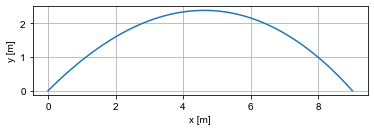

In [21]:
plt.figure(1)

plt.plot(x, y)
plt.grid(1)
plt.gca().set_aspect(1)
plt.xlabel("x [m]")
plt.ylabel("y [m]")

### Plot distance vs V_mag0

In [22]:
# compute velocity components from velocity magnitude and angle
def mag2comp(V_mag, theta):
    return V_mag * np.cos(theta), V_mag * np.sin(theta)

In [23]:
# let's try 10 m/s at 45 degrees
Vx, Vy = mag2comp(10, np.deg2rad(45))

# get sol
t, x, y, Vx, Vy = trajectory_with_stop(0, 0, Vx, Vy)

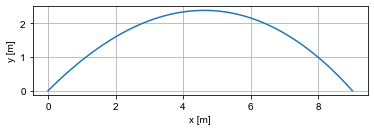

In [24]:
plt.figure(2)
# plt.clf()

plt.plot(x, y)
plt.grid(1)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.gca().set_aspect(1)

In [26]:
# return distance given initial velocity (at 45 degrees)
def distance(V_mag):
    # find velocity components
    Vx, Vy = mag2comp(V_mag, np.deg2rad(45))

    # solve forward
    t, x, y, Vx, Vy = trajectory_with_stop(0, 0, Vx, Vy)
    
    # return final distance
    return x[-1]

In [27]:
# initial velocities
V_mags = np.linspace(1, 10, 20)

# get final distances
distances = [distance(V) for V in V_mags] 

Text(0, 0.5, '|V| [m/s]')

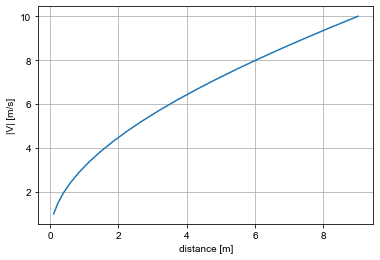

In [29]:
plt.figure(3)

plt.plot(distances, V_mags)
plt.grid(1)
plt.xlabel("distance [m]")
plt.ylabel("|V| [m/s]")